This is a single region case with a set of 3D self-defined noiseless data.  


This script includes three methods:  
    
Finite difference method - The pure FDM with origion data.  

Semi difference method - The function data was smoothed by DDDA, the position 
                        data wasn't change.  
    
DDDA mathod - A sample version which lack of the part of clustering.
  

The formula is:  
<center> <font size = 6 > f = exp(0.1x+0.9y+0.4z) </font> </center>

# Import and draw

<IPython.core.display.Javascript object>


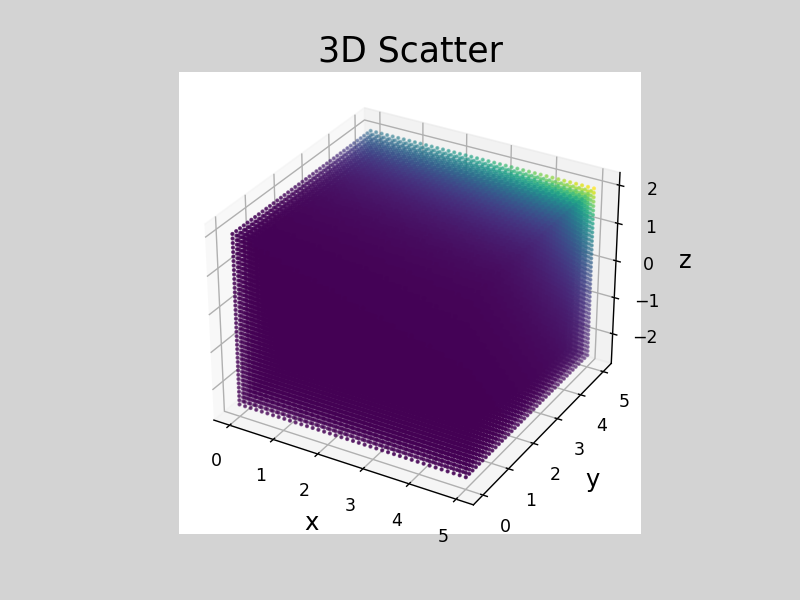

1600


In [1]:
%reset -f
%clear
import numpy as np
import copy
import matplotlib.pyplot as plt 
plt.close('all')
import scipy.io as scio
from mpl_toolkits.mplot3d import axes3d
import pandas as pd
import scipy.stats as stats
import math
from numba import jit # Accelerator
from scipy.spatial import Voronoi, ConvexHull
from sklearn.neighbors import KDTree, KernelDensity
from sklearn.model_selection import GridSearchCV
import platform
import time
import gc
import seaborn as sns

NoPin1D = 40
DataX = scio.loadmat('PositionX_3D.mat')
DataX = DataX['N1']
DataY = scio.loadmat('PositionY_3D.mat')
DataY = DataY['N2']
DataZ = scio.loadmat('PositionZ_3D.mat')
DataZ = DataZ['N3']
DataF = scio.loadmat('Data_3D.mat')
DataF = DataF['DataOut']

%matplotlib notebook
plt.figure("3D Scatter", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('3D Scatter', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)

ax3d.scatter(DataX, DataY, DataZ, c = DataF,s = 2)
plt.show()

NoPs = 40 * 40 # Points in one outend surface
print(NoPs)

# Import data and draw.

# Dataset pre-treatment
## Boundary reflection

In general case, the voronoi algorithm always come along with messy boundary and some couple of extrame points.
In order to obtain the volumn information by the most of voronoi cell, we developed this specific algorithm which attach closely with the thoery of voronoi cell generation.  
In this part we reflected the points in each boundary respect with the boundary's norm axis.

In [2]:
# Temporary parameter for boundary reflection
X_mid = (max(DataX) - min(DataX))/2 + min(DataX)
Y_mid = (max(DataY) - min(DataY))/2 + min(DataY)
Z_mid = (max(DataZ) - min(DataZ))/2 + min(DataZ)

#Xmin Y-Z plane
DataX_Xmin_Ori = copy.deepcopy(DataX)
DataY_Xmin_Ori = copy.deepcopy(DataY)
DataZ_Xmin_Ori = copy.deepcopy(DataZ)
DataF_Xmin_Ori = copy.deepcopy(DataF)

XMinx_Frame = np.zeros((NoPs,1))
XMiny_Frame = np.zeros((NoPs,1))
XMinz_Frame = np.zeros((NoPs,1))
XMinx_M1 = np.zeros((NoPs,1))
XMiny_M1 = np.zeros((NoPs,1))
XMinz_M1 = np.zeros((NoPs,1))

#Frame - The reference line
for PtN in range(NoPs):
    PT_temp = DataX_Xmin_Ori.argmin()
    XMinx_Frame[PtN] = DataX_Xmin_Ori[PT_temp]
    XMiny_Frame[PtN] = DataY_Xmin_Ori[PT_temp]
    XMinz_Frame[PtN] = DataZ_Xmin_Ori[PT_temp]

    DataX_Xmin_Ori[PT_temp] = X_mid
    DataY_Xmin_Ori[PT_temp] = Y_mid
    DataZ_Xmin_Ori[PT_temp] = Z_mid

# M1 & M1m Line 
for PtN in range(NoPs):
    PT_temp = DataX_Xmin_Ori.argmin()
    XMinx_M1[PtN] = DataX_Xmin_Ori[PT_temp]
    XMiny_M1[PtN] = DataY_Xmin_Ori[PT_temp]
    XMinz_M1[PtN] = DataZ_Xmin_Ori[PT_temp]

# Cutting Reflection
XMinx_FrameR = -1 * XMinx_Frame
Xmin_Offset = np.abs(np.mean(XMinx_Frame - XMinx_M1))
Xmin_GAP = np.abs(np.mean(XMinx_Frame - XMinx_FrameR))
XMinx_CR = XMinx_FrameR + Xmin_GAP - Xmin_Offset 

DataX_xmin_DONE = np.vstack((DataX, XMinx_CR))
DataY_xmin_DONE = np.vstack((DataY, XMiny_Frame))
DataZ_xmin_DONE = np.vstack((DataZ, XMinz_Frame))

# Left boundary reflection 
# Yellow reflected points, Red Reference points

#Zmin X-Y plane
NoPs = 1640
DataX_Zmin_Ori = copy.deepcopy(DataX_xmin_DONE)
DataY_Zmin_Ori = copy.deepcopy(DataY_xmin_DONE)
DataZ_Zmin_Ori = copy.deepcopy(DataZ_xmin_DONE)

ZMinx_Frame = np.zeros((NoPs,1))
ZMiny_Frame = np.zeros((NoPs,1))
ZMinz_Frame = np.zeros((NoPs,1))
ZMinx_M1 = np.zeros((NoPs,1))
ZMiny_M1 = np.zeros((NoPs,1))
ZMinz_M1 = np.zeros((NoPs,1))

#Frame - The reference line
for PtN in range(NoPs):
    PT_temp = DataZ_Zmin_Ori.argmin()
    ZMinx_Frame[PtN] = DataX_Zmin_Ori[PT_temp]
    ZMiny_Frame[PtN] = DataY_Zmin_Ori[PT_temp]
    ZMinz_Frame[PtN] = DataZ_Zmin_Ori[PT_temp]

    DataX_Zmin_Ori[PT_temp] = X_mid
    DataY_Zmin_Ori[PT_temp] = Y_mid
    DataZ_Zmin_Ori[PT_temp] = Z_mid


# M1 & M1m Line 
for PtN in range(NoPs):
    PT_temp = DataZ_Zmin_Ori.argmin()
    ZMinx_M1[PtN] = DataX_Zmin_Ori[PT_temp]
    ZMiny_M1[PtN] = DataY_Zmin_Ori[PT_temp]
    ZMinz_M1[PtN] = DataZ_Zmin_Ori[PT_temp]

# Cutting Reflection
ZMinz_FrameR = -1 * ZMinz_Frame
Zmin_Offset = np.abs(np.mean(ZMinz_Frame - ZMinz_M1))
Zmin_GAP = np.abs(np.mean(ZMinz_Frame - ZMinz_FrameR))
ZMinz_CR = ZMinz_FrameR - Zmin_GAP - Zmin_Offset

DataX_Zmin_DONE = np.vstack((DataX_xmin_DONE, ZMinx_Frame))
DataY_Zmin_DONE = np.vstack((DataY_xmin_DONE, ZMiny_Frame))
DataZ_Zmin_DONE = np.vstack((DataZ_xmin_DONE, ZMinz_CR))

# Left boundary reflection 
# Yellow reflected points, Red Reference points

#Ymin X-Z plane
NoPs = 1681
DataX_Ymin_Ori = copy.deepcopy(DataX_Zmin_DONE)
DataY_Ymin_Ori = copy.deepcopy(DataY_Zmin_DONE)
DataZ_Ymin_Ori = copy.deepcopy(DataZ_Zmin_DONE)

YMinx_Frame = np.zeros((NoPs,1))
YMiny_Frame = np.zeros((NoPs,1))
YMinz_Frame = np.zeros((NoPs,1))
YMinx_M1 = np.zeros((NoPs,1))
YMiny_M1 = np.zeros((NoPs,1))
YMinz_M1 = np.zeros((NoPs,1))

#Frame - The reference line
for PtN in range(NoPs):
    PT_temp = DataY_Ymin_Ori.argmin()
    YMinx_Frame[PtN] = DataX_Ymin_Ori[PT_temp]
    YMiny_Frame[PtN] = DataY_Ymin_Ori[PT_temp]
    YMinz_Frame[PtN] = DataZ_Ymin_Ori[PT_temp]

    DataX_Ymin_Ori[PT_temp] = X_mid
    DataY_Ymin_Ori[PT_temp] = Y_mid
    DataZ_Ymin_Ori[PT_temp] = Z_mid

# M1 & M1m Line 
for PtN in range(NoPs):
    PT_temp = DataY_Ymin_Ori.argmin()
    YMinx_M1[PtN] = DataX_Ymin_Ori[PT_temp]
    YMiny_M1[PtN] = DataY_Ymin_Ori[PT_temp]
    YMinz_M1[PtN] = DataZ_Ymin_Ori[PT_temp]

# Cutting Reflection
YMiny_FrameR = -1 * YMiny_Frame
Ymin_Offset = np.abs(np.mean(YMiny_Frame - YMiny_M1))
Ymin_GAP = np.abs(np.mean(YMiny_Frame - YMiny_FrameR))
YMiny_CR = YMiny_FrameR + Ymin_GAP - Ymin_Offset

DataX_Ymin_DONE = np.vstack((DataX_Zmin_DONE, YMinx_Frame))
DataY_Ymin_DONE = np.vstack((DataY_Zmin_DONE, YMiny_CR))
DataZ_Ymin_DONE = np.vstack((DataZ_Zmin_DONE, YMinz_Frame))

# Left boundary reflection 
# Yellow reflected points, Red Reference points

#Xmax Y-Z plane
NoPs = 1681
DataX_Xmax_Ori = copy.deepcopy(DataX_Ymin_DONE)
DataY_Xmax_Ori = copy.deepcopy(DataY_Ymin_DONE)
DataZ_Xmax_Ori = copy.deepcopy(DataZ_Ymin_DONE)

XMaxx_Frame = np.zeros((NoPs,1))
XMaxy_Frame = np.zeros((NoPs,1))
XMaxz_Frame = np.zeros((NoPs,1))
XMaxx_M1 = np.zeros((NoPs,1))
XMaxy_M1 = np.zeros((NoPs,1))
XMaxz_M1 = np.zeros((NoPs,1))

#Frame - The reference line
for PtN in range(NoPs):
    PT_temp = DataX_Xmax_Ori.argmax()
    XMaxx_Frame[PtN] = DataX_Xmax_Ori[PT_temp]
    XMaxy_Frame[PtN] = DataY_Xmax_Ori[PT_temp]
    XMaxz_Frame[PtN] = DataZ_Xmax_Ori[PT_temp]

    DataX_Xmax_Ori[PT_temp] = X_mid
    DataY_Xmax_Ori[PT_temp] = Y_mid
    DataZ_Xmax_Ori[PT_temp] = Z_mid


# M1 & M1m Line 
for PtN in range(NoPs):
    PT_temp = DataX_Xmax_Ori.argmax()
    XMaxx_M1[PtN] = DataX_Xmax_Ori[PT_temp]
    XMaxy_M1[PtN] = DataY_Xmax_Ori[PT_temp]
    XMaxz_M1[PtN] = DataZ_Xmax_Ori[PT_temp]

# Cutting Reflection
XMaxx_FrameR = -1 * XMaxx_Frame
Xmax_Offset = np.abs(np.mean(XMaxx_Frame - XMaxx_M1))
Xmax_GAP = np.abs(np.mean(XMaxx_Frame - XMaxx_FrameR))
XMaxx_CR = XMaxx_FrameR + Xmax_GAP + Xmax_Offset

DataX_Xmax_DONE = np.vstack((DataX_Ymin_DONE, XMaxx_CR))
DataY_Xmax_DONE = np.vstack((DataY_Ymin_DONE, XMaxy_Frame))
DataZ_Xmax_DONE = np.vstack((DataZ_Ymin_DONE, XMaxz_Frame))

# Left boundary reflection 
# Yellow reflected points, Red Reference points

#Ymax X-Z plane
NoPs = 1722
DataX_Ymax_Ori = copy.deepcopy(DataX_Xmax_DONE)
DataY_Ymax_Ori = copy.deepcopy(DataY_Xmax_DONE)
DataZ_Ymax_Ori = copy.deepcopy(DataZ_Xmax_DONE)

YMaxx_Frame = np.zeros((NoPs,1))
YMaxy_Frame = np.zeros((NoPs,1))
YMaxz_Frame = np.zeros((NoPs,1))
YMaxx_M1 = np.zeros((NoPs,1))
YMaxy_M1 = np.zeros((NoPs,1))
YMaxz_M1 = np.zeros((NoPs,1))

#Frame - The reference line
for PtN in range(NoPs):
    PT_temp = DataY_Ymax_Ori.argmax()
    YMaxx_Frame[PtN] = DataX_Ymax_Ori[PT_temp]
    YMaxy_Frame[PtN] = DataY_Ymax_Ori[PT_temp]
    YMaxz_Frame[PtN] = DataZ_Ymax_Ori[PT_temp]

    DataX_Ymax_Ori[PT_temp] = X_mid
    DataY_Ymax_Ori[PT_temp] = Y_mid
    DataZ_Ymax_Ori[PT_temp] = Z_mid


# M1 & M1m Line 
for PtN in range(NoPs):
    PT_temp = DataY_Ymax_Ori.argmax()
    YMaxx_M1[PtN] = DataX_Ymax_Ori[PT_temp]
    YMaxy_M1[PtN] = DataY_Ymax_Ori[PT_temp]
    YMaxz_M1[PtN] = DataZ_Ymax_Ori[PT_temp]

# Cutting Reflection
YMaxy_FrameR = -1 * YMaxy_Frame
Ymax_Offset = np.abs(np.mean(YMaxy_Frame - YMaxy_M1))
Ymax_GAP = np.abs(np.mean(YMaxy_Frame - YMaxy_FrameR))
YMaxy_CR = YMaxy_FrameR + Ymax_GAP + Ymax_Offset

DataX_Ymax_DONE = np.vstack((DataX_Xmax_DONE, YMaxx_Frame))
DataY_Ymax_DONE = np.vstack((DataY_Xmax_DONE, YMaxy_CR))
DataZ_Ymax_DONE = np.vstack((DataZ_Xmax_DONE, YMaxz_Frame))

# Left boundary reflection 
# Yellow reflected points, Red Reference points

#Zmax X-Y plane
NoPs = 1764
DataX_Zmax_Ori = copy.deepcopy(DataX_Ymax_DONE)
DataY_Zmax_Ori = copy.deepcopy(DataY_Ymax_DONE)
DataZ_Zmax_Ori = copy.deepcopy(DataZ_Ymax_DONE)

ZMaxx_Frame = np.zeros((NoPs,1))
ZMaxy_Frame = np.zeros((NoPs,1))
ZMaxz_Frame = np.zeros((NoPs,1))
ZMaxx_M1 = np.zeros((NoPs,1))
ZMaxy_M1 = np.zeros((NoPs,1))
ZMaxz_M1 = np.zeros((NoPs,1))

#Frame - The reference line
for PtN in range(NoPs):
    PT_temp = DataZ_Zmax_Ori.argmax()
    ZMaxx_Frame[PtN] = DataX_Zmax_Ori[PT_temp]
    ZMaxy_Frame[PtN] = DataY_Zmax_Ori[PT_temp]
    ZMaxz_Frame[PtN] = DataZ_Zmax_Ori[PT_temp]

    DataX_Zmax_Ori[PT_temp] = X_mid
    DataY_Zmax_Ori[PT_temp] = Y_mid
    DataZ_Zmax_Ori[PT_temp] = Z_mid

# M1 & M1m Line 
for PtN in range(NoPs):
    PT_temp = DataZ_Zmax_Ori.argmax()
    ZMaxx_M1[PtN] = DataX_Zmax_Ori[PT_temp]
    ZMaxy_M1[PtN] = DataY_Zmax_Ori[PT_temp]
    ZMaxz_M1[PtN] = DataZ_Zmax_Ori[PT_temp]

# Cutting Reflection
ZMaxz_FrameR = -1 * ZMaxz_Frame
Zmax_Offset = np.abs(np.mean(ZMaxz_Frame - ZMaxz_M1))
Zmax_GAP = np.abs(np.mean(ZMaxz_Frame - ZMaxz_FrameR))
ZMaxz_CR = ZMaxz_FrameR + Zmax_GAP + Zmax_Offset

DataX_Zmax_DONE = np.vstack((DataX_Ymax_DONE, ZMaxx_Frame))
DataY_Zmax_DONE = np.vstack((DataY_Ymax_DONE, ZMaxy_Frame))
DataZ_Zmax_DONE = np.vstack((DataZ_Ymax_DONE, ZMaxz_CR))

print(len(DataX_Zmax_DONE))

74088


## Engaging voronoi cell and determine the volumn for each cell


In [3]:
# Apply voronoi cell algorithm
Data3D_x = copy.deepcopy(DataX_Zmax_DONE)
Data3D_y = copy.deepcopy(DataY_Zmax_DONE)
Data3D_z = copy.deepcopy(DataZ_Zmax_DONE)
Data3D = np.hstack((Data3D_x, Data3D_y, Data3D_z))
type(Data3D)

vor = Voronoi(Data3D) # use voronoi cell package
# This package return two variables
# vor.vertices return vertex coordinates in each dimention
# vor.regions return a list of voronoi cell, the cell represent by a element   
# the vertex is reserved in element by index. 
vor_vertices = copy.deepcopy(vor.vertices)
vor_regions = copy.deepcopy(vor.regions)

OriginNoCell = len(vor_regions)

NoVoronoiCell = len(vor.regions)
V_vertices_x = copy.deepcopy(vor.vertices[:, 0])
V_vertices_y = copy.deepcopy(vor.vertices[:, 1])
V_vertices_z = copy.deepcopy(vor.vertices[:, 2])

XMax = np.max(XMaxx_CR - 0.3 * Xmax_Offset)
YMax = np.max(YMaxy_CR - 0.3 * Ymax_Offset)
ZMax = np.max(ZMaxz_CR - 0.3 * Zmax_Offset)
XMin = np.max(XMinx_CR - 0.3 * Xmin_Offset)
YMin = np.max(YMiny_CR - 0.3 * Ymin_Offset)
ZMin = np.max(ZMinz_CR - 0.3 * Zmax_Offset)

V_coord_x = [ [] for _ in range(NoVoronoiCell) ]
V_coord_y = [ [] for _ in range(NoVoronoiCell) ]
V_coord_z = [ [] for _ in range(NoVoronoiCell) ]

# Merge the vertex index and its coordinates
for i in range(NoVoronoiCell):

    DeleteHint = 0;
    VL_Temp = len(vor.regions[i])

    if VL_Temp == 0:
        continue
        
    V_coord_x[i] = np.zeros(VL_Temp)
    V_coord_y[i] = np.zeros(VL_Temp)
    V_coord_z[i] = np.zeros(VL_Temp)
    Ori_Check_x = np.zeros(VL_Temp)
    Ori_Check_y = np.zeros(VL_Temp)
    Ori_Check_z = np.zeros(VL_Temp)
    
    for j in range(VL_Temp):
        NoC = vor.regions[i][j]
        V_coord_x[i][j] = V_vertices_x[NoC]
        V_coord_y[i][j] = V_vertices_y[NoC]
        V_coord_z[i][j] = V_vertices_z[NoC]
        
NewIndex = 0
NewV_coord_x = list()
NewV_coord_y = list()
NewV_coord_z = list()

for NoC in range(len(vor.regions)):
    if len(V_coord_x[NoC]) == 0:
        continue
    elif len(V_coord_x[NoC]) != 0 and NewIndex == 0:
        NewV_coord_x.append(V_coord_x[NoC])
        NewV_coord_y.append(V_coord_y[NoC])
        NewV_coord_z.append(V_coord_z[NoC])
        NewIndex = NewIndex + 1
    else:
        NewV_coord_x.append(V_coord_x[NoC])
        NewV_coord_y.append(V_coord_y[NoC])
        NewV_coord_z.append(V_coord_z[NoC])
        NewIndex = NewIndex + 1

# Determine the voronoi cell volumn by QHull package
VolVoeSubj = np.zeros(NewIndex)
OutBoundaryCount = 0

for i in range(NewIndex):
    CellL = len(NewV_coord_x[i])
    xxx = np.zeros((CellL, 3))
    WrongCell = 0

    for j in range(CellL):
        
        xxx[j][0] = NewV_coord_x[i][j]
        xxx[j][1] = NewV_coord_y[i][j]
        xxx[j][2] = NewV_coord_z[i][j]
    try:
        vvvv = ConvexHull(xxx)
    except:
        VolVoeSubj[i] = 0
        OutBoundaryCount = OutBoundaryCount + 1
    else:
        VolVoeSubj[i] = vvvv.volume

NewNoPCell = len(VolVoeSubj)

print('\n The domain volume by untrimed Qhull: \n', np.sum(VolVoeSubj))
print('\n The domain volume for real: \n', 137.5)

print('\n The volume of a cell should around: \n', 0.00215)

print('\n The biggist and smallest cell: \n', max(VolVoeSubj), min(VolVoeSubj))

print('\n Number of cell out of boundary which treated as empty(Error part): \n', \
      OutBoundaryCount)

print('\n The total number of cell: \n', NewNoPCell)


 The domain volume by untrimed Qhull: 
 242.75527234107113

 The domain volume for real: 
 137.5

 The volume of a cell should around: 
 0.00215

 The biggist and smallest cell: 
 0.024654832347140367 0.0

 Number of cell out of boundary which treated as empty(Error part): 
 488

 The total number of cell: 
 74088


<IPython.core.display.Javascript object>


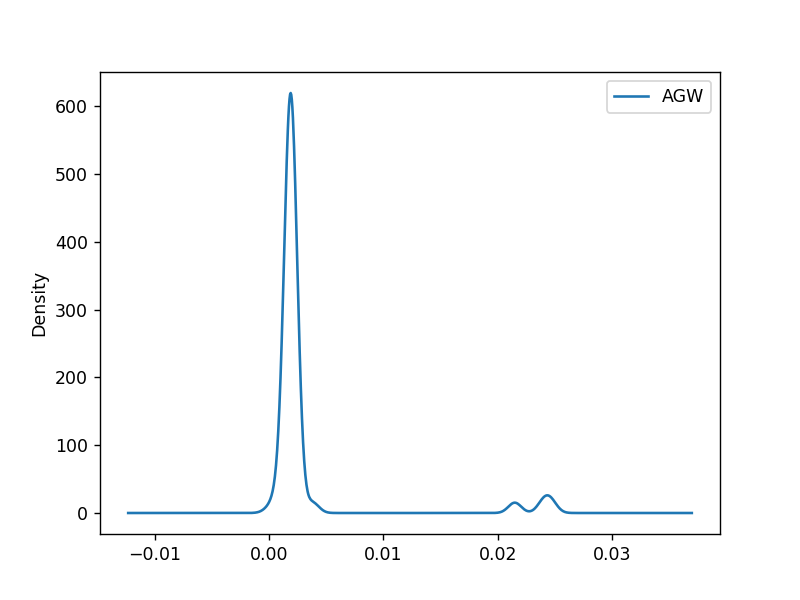

<IPython.core.display.Javascript object>


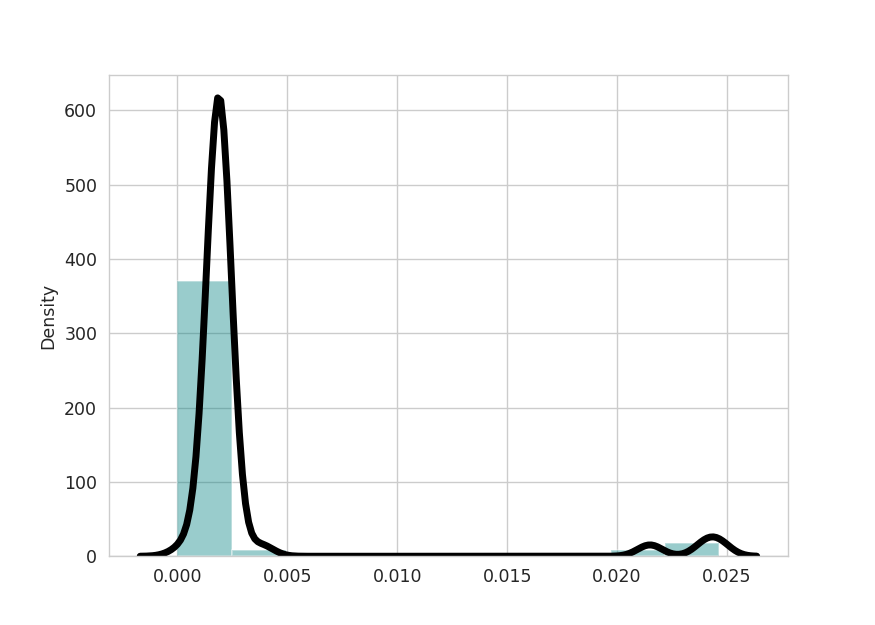

/tmp/ipykernel_5556/512915977.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x = df["AGW"], bins = 10 , kde = True , color = 'teal'


In [4]:
# See how volumn distribute
x = VolVoeSubj  #Generating Data
source = {"Genotype": ["CV1"] * len(x), "AGW": x}
df=pd.DataFrame(source) #Converting to pandas DataFrame
df.plot(kind = 'density'); # or df["AGW"].plot(kind = 'density');

sns.set_style("whitegrid")  # Setting style(Optional)
plt.figure(figsize = (7,5)) #Specify the size of figure 
sns.distplot(x = df["AGW"], bins = 10 , kde = True , color = 'teal'
            , kde_kws=dict(linewidth = 4 , color = 'black')) #kde for normal distribution
plt.show()

## Delate the bad cell

<IPython.core.display.Javascript object>


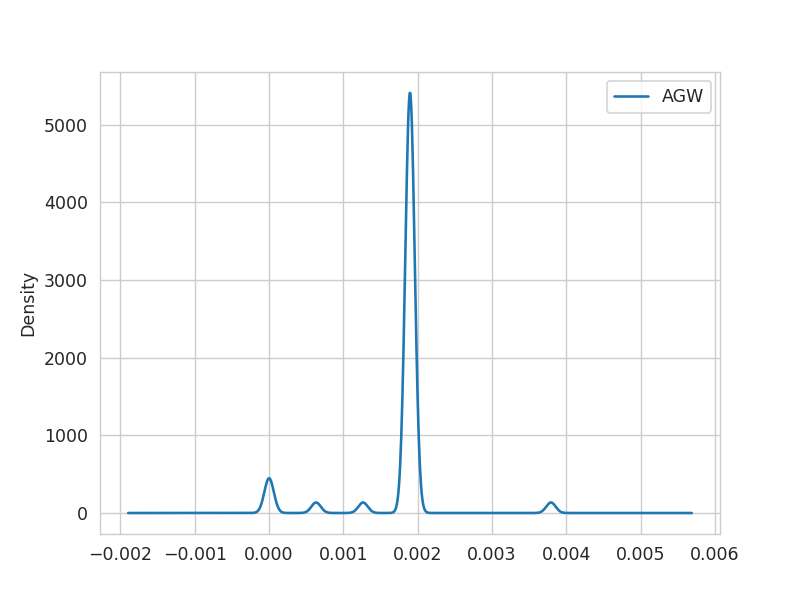

<IPython.core.display.Javascript object>


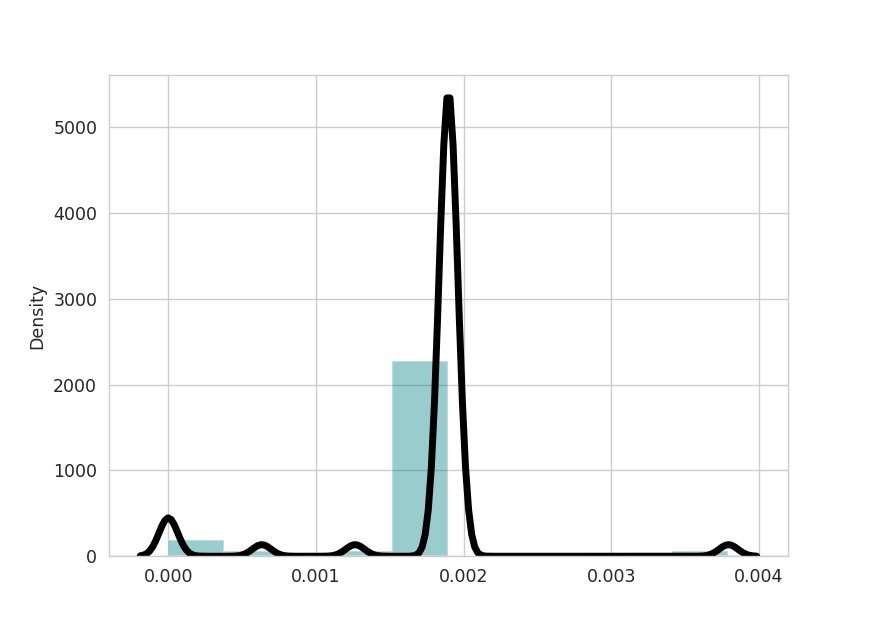

/tmp/ipykernel_5556/3736737510.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x = df["AGW"], bins = 10 , kde = True , color = 'teal'


In [5]:
for i in range(NewNoPCell):
    if VolVoeSubj[i] > 0.01:
        VolVoeSubj[i] = 0
        
x = VolVoeSubj  #Generating Data
source = {"Genotype": ["CV1"] * len(x), "AGW": x}
df=pd.DataFrame(source) #Converting to pandas DataFrame
df.plot(kind = 'density'); # or df["AGW"].plot(kind = 'density');

sns.set_style("whitegrid")  # Setting style(Optional)
plt.figure(figsize = (7,5)) #Specify the size of figure 
sns.distplot(x = df["AGW"], bins = 10 , kde = True , color = 'teal'
            , kde_kws=dict(linewidth = 4 , color = 'black')) #kde for normal distribution
plt.show()        

In [6]:
print(np.sum(VolVoeSubj))

130.48095888332574


## Setting interpolation points

In [6]:
# When assigning interpolationg points, its better to avoid the points in 
# edge-end in order to keep the kernel in good shape.
# A better algorithm nearly complate, it will update soon.
Inter_Left_x = 0.2
Inter_Right_x = 4.8
Inter_Left_y = 0.2
Inter_Right_y = 4.8
Inter_Left_z = -2.3
Inter_Right_z = 1.8

n = 40
Inter_Data_x = np.linspace(Inter_Left_x, Inter_Right_x, num = n)
Inter_Data_y = np.linspace(Inter_Left_y, Inter_Right_y, num = n)
Inter_Data_z = np.linspace(Inter_Left_z, Inter_Right_z, num = n)

x_Inter = np.zeros(pow(n, 3))
y_Inter = np.zeros(pow(n, 3))
z_Inter = np.zeros(pow(n, 3))

for xIndex in range(n):
    for yIndex in range(n):
        for zIndex in range(n):
            
            x_Inter[xIndex * n * n + yIndex  * n + zIndex] = \
            Inter_Data_x[xIndex]
            y_Inter[xIndex * n * n + yIndex  * n + zIndex] = \
            Inter_Data_y[yIndex]
            z_Inter[xIndex * n * n + yIndex  * n + zIndex] = \
            Inter_Data_z[zIndex]
            
x_Inter = np.reshape(x_Inter, (len(x_Inter), 1))
y_Inter = np.reshape(y_Inter, (len(y_Inter), 1))
z_Inter = np.reshape(z_Inter, (len(z_Inter), 1))

In [69]:
## Setting truncate range
# The memory complexity increse exponentially along with the increase of data 
# dimension. Consering about the generlisation the exhuastive method is not
# feasible, so we have to involve data strcture algorithm to trancate the data
# in acceptable range, in this script, we use K-D tree.

# Furthermore, we made a double convergence algorithm that let the trancate 
# length and support range adaptively fit any form of data which around our 
# interpolate point.

T1 = time.perf_counter()

DataSet_3D = np.hstack((DataX, DataY, DataZ))
InterSet_3D = np.hstack((x_Inter, y_Inter, z_Inter))

RoughMinAxis = min([XMax-XMin, YMax-YMin, ZMax-ZMin])
RoughMindis = RoughMinAxis / NoPin1D

# Truncation paremeter
Trunc_r_0 = RoughMindis * 4
Trunc_r_1 = Trunc_r_0 * 2.5
Trunc_rn = 10

Trunc_r_range = np.linspace(Trunc_r_0, Trunc_r_1, Trunc_rn)

def DomainCutoff(DataSet, Interpoints, r_range, rn):
    PoinsInd = []
    distance = []
    
    tree = KDTree(DataSet)  # Assign K-D tree
    for i in range(rn):

        PoinsInd_one, distance_one = tree.query_radius(Interpoints, \
                                                       r = r_range[i], \
                                    return_distance=True)
        PoinsInd.append(PoinsInd_one)
        distance.append(distance_one)
    return PoinsInd, distance

PoinsInd, distance, = DomainCutoff(DataSet_3D, InterSet_3D, \
                                              Trunc_r_range, Trunc_rn)

T2 = time.perf_counter()
print(T2 - T1)


38.79259259299988


In [70]:
T1 = time.perf_counter()

# Support domain paremeter
h_0 = Trunc_r_0 * 1
h_1 = h_0 * 2
hn = 10
h_range = np.linspace(h_0, h_1, hn)

# Gaussion constant coordinate
aGau = list(map(lambda x: 1 / (pow(math.pi, 1.5) * pow(x, 3)), h_range))
aGau = np.array(aGau)

# Gaussian kernel with varis support domain & truncate domain
@jit(nopython=True)
def DistanceAll(distance, PoinsIndNP, VolVoeSubj, aGau, h):
                
    N_Data = len(distance)
    W_Gau_0th = 0
    W_Gau_1st = 0
            
    for j in range(N_Data):
        
        q = distance[j] / h
        W_GauN = aGau * math.exp( -1 * math.pow(q, 2))
        # 0th moment
        W_Gau_0th = W_Gau_0th + W_GauN * VolVoeSubj[PoinsIndNP[j]]
        # 1st moment
        W_Gau_1st = W_Gau_1st + \
        W_GauN * VolVoeSubj[PoinsIndNP[j]] * math.pow(distance[j], 1)
        
    return(W_Gau_0th, W_Gau_1st, N_Data)

Q_length = len(distance[0])
W_Gau_0th_vari = np.zeros((Trunc_rn, hn, Q_length))
W_Gau_1st_vari = np.zeros((Trunc_rn, hn, Q_length))
N_Data = np.zeros((Trunc_rn, Q_length))
for k in range(Trunc_rn):
    distanceNP = np.array(distance[k][0:])
    PoinsIndNP = np.array(PoinsInd[k])

    for j in range(hn):
        aGauNP = aGau[j]
        h = h_range[j]
        for i in range(Q_length) :
            W_Gau_0th_vari[k, j, i], W_Gau_1st_vari[k, j, i], N_Data[k, i]= \
            DistanceAll(distanceNP[i], PoinsIndNP[i], VolVoeSubj, \
                                    aGauNP, h)

T2 = time.perf_counter()
print(T2 - T1)

59.56935463900004


[[0.34062943 0.27225609 0.21933023 0.17831772 0.1463582  0.1212566
  0.10136561 0.08545825 0.07262044 0.06216825]
 [0.41635532 0.34118085 0.28037063 0.23160522 0.19256292 0.16122837
  0.13595957 0.11545899 0.09871587 0.08494718]
 [0.48062043 0.40449795 0.33983528 0.28588985 0.24129938 0.20457165
  0.17431744 0.14933684 0.12863317 0.11139572]
 [0.52222071 0.4488207  0.38394849 0.32798098 0.2804135  0.24032276
  0.20666349 0.1784269  0.15471096 0.13474191]
 [0.56026148 0.49328588 0.43134454 0.37562609 0.3265234  0.28384812
  0.24708045 0.21555708 0.18858848 0.16552238]
 [0.5827404  0.52278552 0.46560821 0.41239934 0.36397404 0.32066137
  0.28240153 0.24888703 0.21968195 0.19430456]
 [0.59553257 0.54137089 0.48888548 0.43885785 0.39215256 0.34936185
  0.31073976 0.27626312 0.24572322 0.21880678]
 [0.6051929  0.55736316 0.51095054 0.46585761 0.42260791 0.38182957
  0.34400074 0.30937903 0.27802247 0.24984129]
 [0.60938484 0.56536124 0.52321215 0.48211673 0.44213358 0.40370774
  0.36733279 

<IPython.core.display.Javascript object>


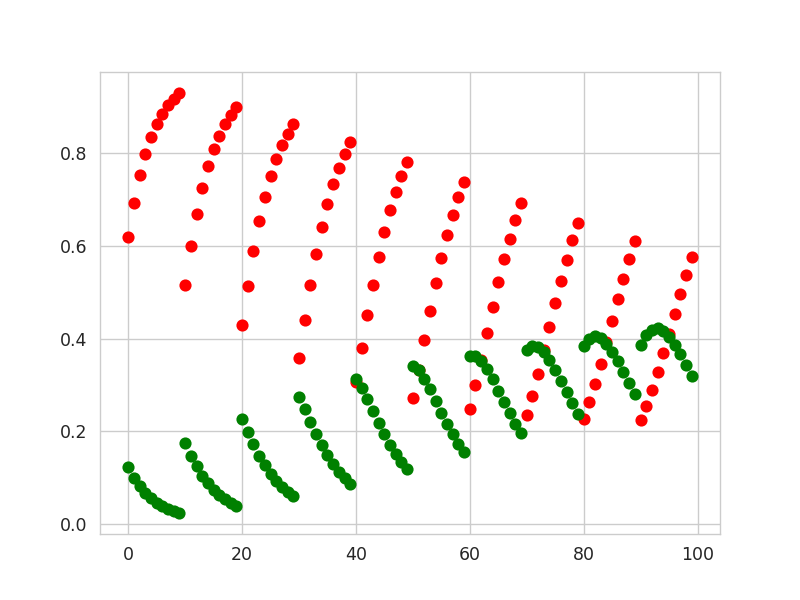

[0.74054188 0.79306167 0.83355288 0.86483993 0.88916892 0.90824624
 0.92334415 0.93540601 0.94513225 0.95304564 0.69093446 0.74782611
 0.79343522 0.82977918 0.85874183 0.88190528 0.90053409 0.91561524
 0.92791095 0.93800803 0.65499513 0.71265834 0.76057092 0.79988931
 0.83198369 0.85816178 0.8795595  0.89711756 0.91159554 0.92359888
 0.63191046 0.68810613 0.73616796 0.77662975 0.81038758 0.83843604
 0.86172253 0.88108354 0.89722743 0.91074003 0.618663   0.67263246
 0.71968132 0.76006076 0.7943551  0.82330382 0.84767199 0.86817623
 0.88545121 0.90004061 0.61243281 0.66457444 0.71042284 0.75020612
 0.78438363 0.81355234 0.83835458 0.85941396 0.87729996 0.89251314
 0.61021211 0.66135758 0.70640307 0.74564513 0.77953304 0.80861756
 0.83348665 0.85471494 0.87283295 0.88831242 0.60996702 0.6609708
 0.70588889 0.74503415 0.77885986 0.80791347 0.83277656 0.8540171
 0.87215971 0.88767151 0.61041129 0.66182639 0.70720918 0.74679327
 0.78098001 0.81029567 0.83532265 0.85664156 0.8747941  0.890264

<IPython.core.display.Javascript object>


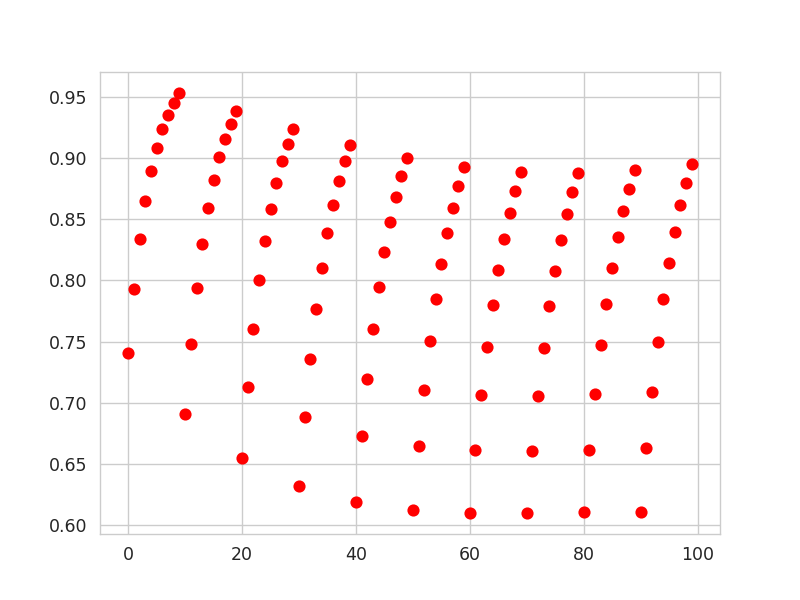

In [71]:
# Choice random point, show how it going converge.
print(W_Gau_0th_vari[:, :, 1000])
print(W_Gau_1st_vari[:, :, 1000])

# Distance of 0th moment to its target value 1
W0th_abs = np.reshape(abs(W_Gau_0th_vari[:, :, 10000] - 1), Trunc_rn * hn)
# 1st moment
W1st = np.reshape(W_Gau_1st_vari[:, :, 10000], Trunc_rn * hn)

orderr = np.linspace(0, Trunc_rn * hn - 1, Trunc_rn * hn)
plt.figure()
plt.scatter(orderr, W0th_abs, c = 'r')
plt.scatter(orderr, W1st, c = 'g')

# The distance between 2 moment to target value(0 and 1)
Choice = W0th_abs + W1st
print(Choice)

plt.figure()
plt.scatter(orderr, Choice, c = 'r')

In [72]:
# Chioce the 0th and 1st moment parameter that are the most close to the 
# target value

W_Gau_0th_fix = np.zeros(Q_length)
W_Gau_1st_fix = np.zeros(Q_length)
Trunc_r_fix = np.zeros(Q_length)
Distance_r_fix_index = np.zeros(Q_length)
h_fix = np.zeros(Q_length)

for j in range(Q_length):

    W0th_abs = np.reshape(abs(W_Gau_0th_vari[:, :, j] - 1), Trunc_rn * hn)
    W1st = np.reshape(W_Gau_1st_vari[:, :, j], Trunc_rn * hn)
    Choice = W0th_abs + W1st

    MCT = np.zeros((3, 2))
    MCT_Weighted = np.zeros((3, 1))
    for i in range(3):
        MCT[i, 0] = min(Choice)
        MCT[i, 1] = Choice.argmin()
        Choice[int(MCT[i, 1])] = Choice[int(MCT[0, 1])] + 1

    for i in range(3):
        MCT_Weighted[i, 0] = MCT[i, 0] * (MCT[i, 1] / 100)

    MCT_0 = min(MCT_Weighted[:, 0])
    MCT_Weighted_index = MCT_Weighted[:, 0].argmin()

    MCT_0_index = MCT[MCT_Weighted_index, 1]

    MCT_index_row = int(MCT_0_index // 10)
    MCT_index_column = int(MCT_0_index % 10)
    
    # Randomly pick a point and see its PDF for a slance check.
    W_Gau_0th_fix[j] = W_Gau_0th_vari[MCT_index_row, MCT_index_column, 1000]
    W_Gau_1st_fix[j] = W_Gau_1st_vari[MCT_index_row, MCT_index_column, 1000]
    Trunc_r_fix[j] = Trunc_r_range[MCT_index_row]
    
    # Two key paremeters, will use in kernel derivateve
    Distance_r_fix_index[j] = MCT_index_row
    h_fix[j] = h_range[MCT_index_column]
    

64000
[0.59553257 0.59553257 0.59553257 ... 0.59553257 0.59553257 0.59553257]


<IPython.core.display.Javascript object>


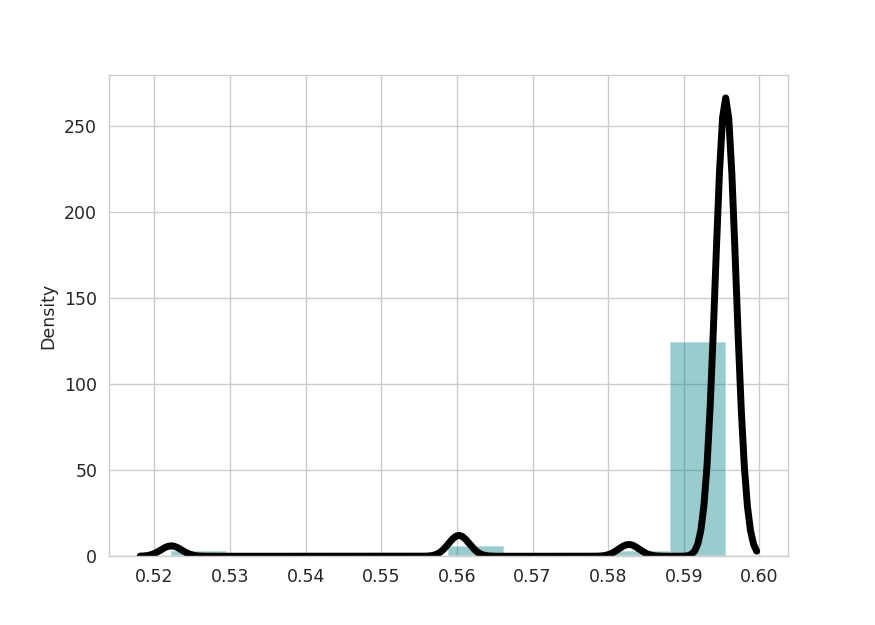

64000
[0.26935613 0.26935613 0.26935613 ... 0.26935613 0.26935613 0.26935613]


/tmp/ipykernel_4052/2773553525.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x = df["AGW"]   ,  bins = 10 , kde = True , color = 'teal'


<IPython.core.display.Javascript object>


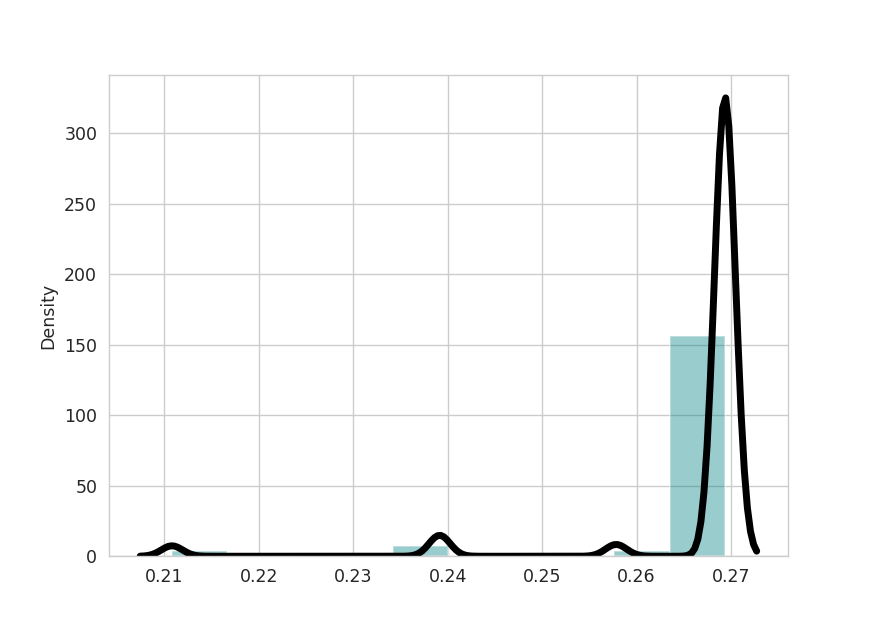

/tmp/ipykernel_4052/2773553525.py:29: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x = df["AGW"]   ,  bins = 10 , kde = True , color = 'teal'


In [73]:
# 0th moment in choicen point
print(len(W_Gau_0th_fix))
a = W_Gau_0th_fix
a = a.reshape(1, n**3)
print(a[0])

x = a[0]  #Generating Data
source = {"Genotype": ["CV1"] * len(x), "AGW": x}
df=pd.DataFrame(source) #Converting to pandas DataFrame

sns.set_style("whitegrid")  # Setting style(Optional)
plt.figure(figsize = (7,5)) #Specify the size of figure
sns.distplot(x = df["AGW"]   ,  bins = 10 , kde = True , color = 'teal'
            , kde_kws=dict(linewidth = 4 , color = 'black')) #kde for normal distribution
plt.show()

# 1st moment in choicen point
print(len(W_Gau_1st_fix))
a = W_Gau_1st_fix
a = a.reshape(1, n**3)
print(a[0])

x = a[0]  #Generating Data
source = {"Genotype": ["CV1"] * len(x), "AGW": x}
df=pd.DataFrame(source) #Converting to pandas DataFrame

sns.set_style("whitegrid")  # Setting style(Optional)
plt.figure(figsize = (7,5)) #Specify the size of figure
sns.distplot(x = df["AGW"]   ,  bins = 10 , kde = True , color = 'teal'
            , kde_kws=dict(linewidth = 4 , color = 'black')) #kde for normal distribution
plt.show()

[[1.87019421e-01 2.15130862e-01 2.40800847e-01 ... 2.82464092e+02
  2.75402317e+02 2.58108971e+02]]
[[2.23130160e-01 2.39124909e-01 2.56266218e-01 ... 7.07359103e+02
  7.58065073e+02 8.12405825e+02]]


<IPython.core.display.Javascript object>


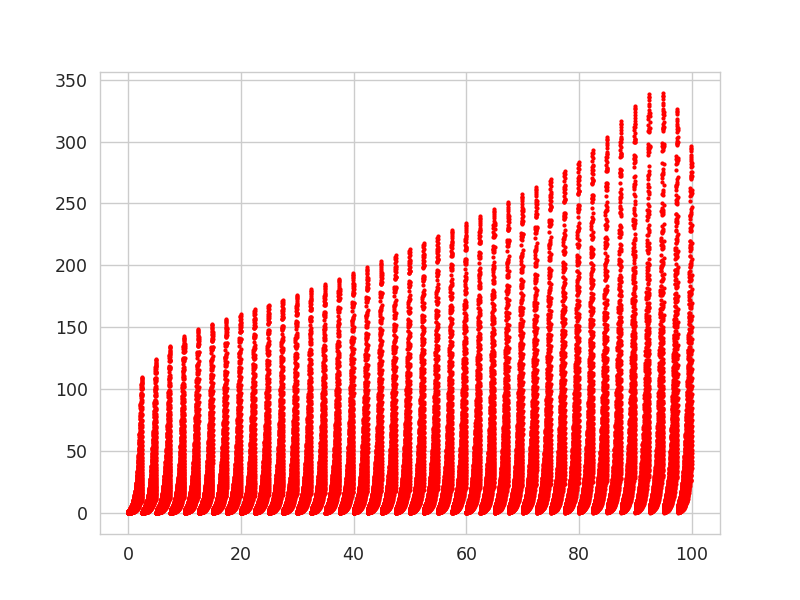

<IPython.core.display.Javascript object>


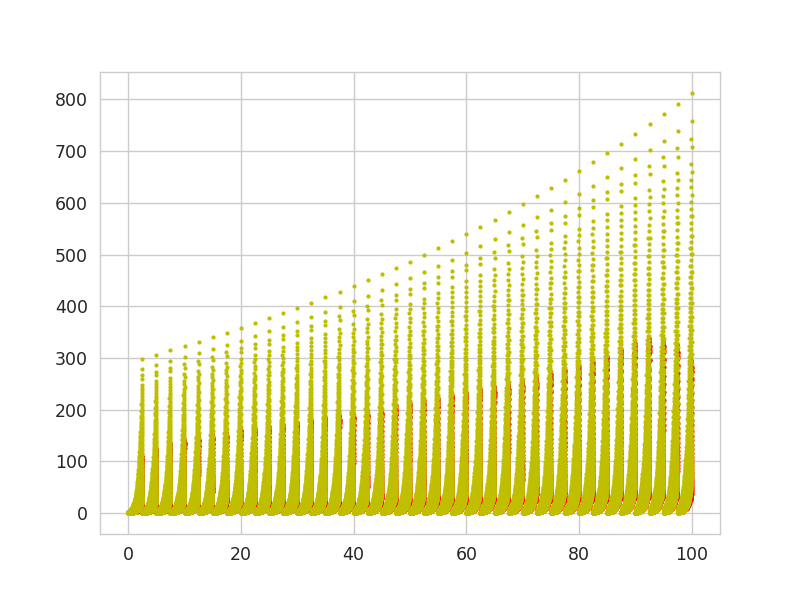

In [74]:
# Show how well the origin data out of by our smooth algorithm with choice
# parameter.

W_GauProve = np.zeros((Q_length, 1))

@jit(nopython=True)
def DistanceAllP(distance, PoinsIndex, VolVoeSubj, h, DataF):

    W_Gauij = 0
    N_Data = len(distance)
    aGau = 1 / (pow(math.pi, 1.5) * pow(h, 3))    
    for j in range(N_Data):
        
        q = distance[j] / h
        W_GauN = aGau * math.exp( -1 * math.pow(q, 2))
        W_Gauij = W_Gauij + W_GauN * VolVoeSubj[PoinsIndex[j]] * \
        DataF[PoinsIndex[j]][0]

    return(W_Gauij)

for i in range(Q_length) :
    r_index = int(Distance_r_fix_index[i])

    W_GauProve[i] = DistanceAllP(distance[r_index][i], \
                                 PoinsInd[r_index][i], \
                                 VolVoeSubj, \
                                h_fix[i], DataF)

print(W_GauProve.transpose())
print(DataF.transpose())

Inter_Plot = np.linspace(0, 100, len(W_GauProve))
Data_Plot = np.linspace(0, 100, len(DataF))
plt.figure()
plt.scatter(Inter_Plot, W_GauProve, s = 2, c = 'r')

plt.figure()
plt.scatter(Inter_Plot, W_GauProve, s = 2, c = 'r')
plt.scatter(Data_Plot, DataF, s = 2, c = 'y')

<IPython.core.display.Javascript object>


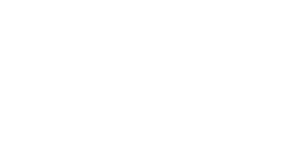

<IPython.core.display.Javascript object>


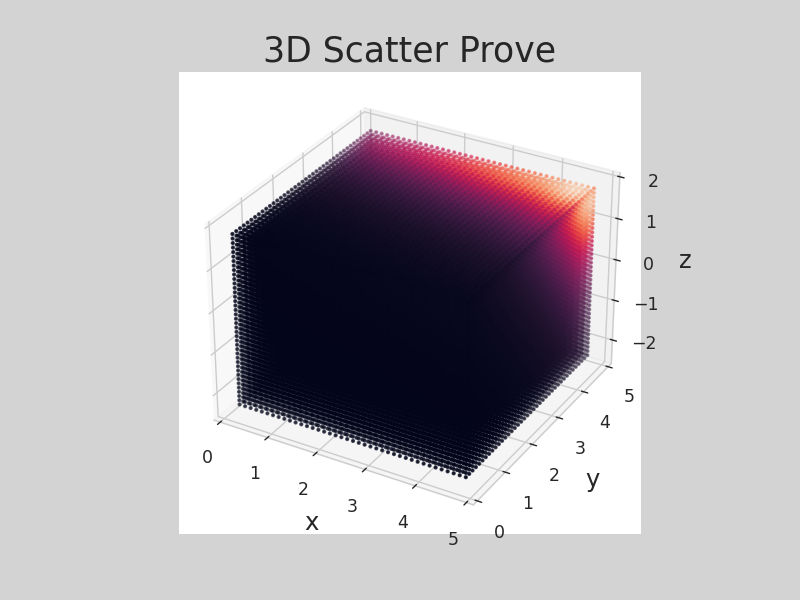

In [75]:
# Origin data in 3D

%matplotlib notebook
plt.figure("3D Scatter Ori", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('3D Scatter Ori', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)

ax3d.scatter(DataX, DataY, DataZ, c = DataF,s = 2)
plt.show()

%matplotlib notebook
plt.figure("3D Scatter Prove", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('3D Scatter Prove', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)

ax3d.scatter(x_Inter, y_Inter, z_Inter, c = W_GauProve,s = 2)
plt.show()

In [76]:
# Determine the partial derivative along each dimension

T1 = time.perf_counter()

W_GauProvePD = np.zeros((Q_length, 1))
Gauij_dev_x = np.zeros((Q_length, 1))
Gauij_dev_y = np.zeros((Q_length, 1))
Gauij_dev_z = np.zeros((Q_length, 1))
Gx = np.zeros((Q_length, 1)) 

@jit(nopython=True)
def PD_fix(distance, PoinsIndex, VolVoeSubj, h, DataF, DataX, DataY, \
                                 DataZ, x_Inter, y_Inter, z_Inter):
    W_Gauij = 0
    Gauij_dev_x = 0
    Gauij_dev_y = 0
    Gauij_dev_z = 0
    
    N_Data = len(distance)
    aGau = 1 / (pow(math.pi, 1.5) * (h ** 3))    
    for j in range(N_Data):
        
        q = distance[j] / h
        W_GauN = aGau * math.exp( -1 * math.pow(q, 2))
        W_Gauij = W_Gauij + W_GauN * VolVoeSubj[PoinsIndex[j]] * \
        DataF[PoinsIndex[j]][0]
        
        dx = (x_Inter - DataX[PoinsIndex[j]]) / distance[j]
        dy = (y_Inter - DataY[PoinsIndex[j]]) / distance[j]
        dz = (z_Inter - DataZ[PoinsIndex[j]]) / distance[j]
    
        Gau_dev_x = dx * aGau * \
        math.exp(-1 * q * q) * (-2 * distance[j] / (h * h))
        
        Gauij_dev_x = Gauij_dev_x + Gau_dev_x[0] * \
        VolVoeSubj[PoinsIndex[j]] * DataF[PoinsIndex[j]][0]  

        Gau_dev_y = dy * aGau * \
        math.exp(-1 * q * q) * (-2 * distance[j] / (h * h))
        
        Gauij_dev_y = Gauij_dev_y + Gau_dev_y[0] * \
        VolVoeSubj[PoinsIndex[j]] * DataF[PoinsIndex[j]][0] 
        
        Gau_dev_z = dz * aGau * \
        math.exp( -1 * q * q) * (-2 * distance[j] / (h * h))
        
        Gauij_dev_z = Gauij_dev_z + Gau_dev_z[0] * \
        VolVoeSubj[PoinsIndex[j]] * DataF[PoinsIndex[j]][0] 
        
    return(W_Gauij, Gauij_dev_x, Gauij_dev_y, Gauij_dev_z)


for i in range(Q_length) :
    r_index = int(Distance_r_fix_index[i])

    W_GauProvePD[i], Gauij_dev_x[i], Gauij_dev_y[i], Gauij_dev_z[i]  = \
    PD_fix(distance[r_index][i], PoinsInd[r_index][i], \
                                 VolVoeSubj, h_fix[i], DataF, DataX, DataY, \
                                 DataZ, x_Inter[i], y_Inter[i], z_Inter[i])

T2 = time.perf_counter()
print(T2 - T1)

19.812979310999935


In [77]:
# Partial derivative in finite difference method

DataX_FD = copy.deepcopy(DataX)
DataY_FD = copy.deepcopy(DataY)
DataZ_FD = copy.deepcopy(DataZ)

DataF_FD = copy.deepcopy(DataF)

nnn = 40

DataF_FD = np.reshape(DataF_FD, (nnn, nnn, nnn))
DataX_FD = np.reshape(DataX_FD, (nnn, nnn, nnn))
DataY_FD = np.reshape(DataY_FD, (nnn, nnn, nnn))
DataZ_FD = np.reshape(DataZ_FD, (nnn, nnn, nnn))

DF_x = np.diff(DataF_FD, axis = 0)
DF_y = np.diff(DataF_FD, axis = 1)
DF_z = np.diff(DataF_FD, axis = 2)

X_FD = copy.deepcopy(DataX_FD)
Y_FD = copy.deepcopy(DataY_FD)
Z_FD = copy.deepcopy(DataZ_FD)

Dx_FD = np.diff(X_FD, axis = 0)
Dy_FD = np.diff(Y_FD, axis = 1)
Dz_FD = np.diff(Z_FD, axis = 2)

DFDx = DF_x / Dx_FD
DFDy = DF_y / Dy_FD
DFDz = DF_z / Dz_FD

DFDxL = np.zeros(64000)
DFDyL = np.zeros(64000)
DFDzL = np.zeros(64000)

nnnn = 40 -1

for i in range(nnnn):
    for j in range(nnnn):
        for k in range(nnnn):
            DFDxL[nnnn * nnnn * i + nnnn * j + k] = DFDx[i][j][k]
            DFDyL[nnnn * nnnn * i + nnnn * j + k] = DFDy[i][j][k]
            DFDzL[nnnn * nnnn * i + nnnn * j + k] = DFDz[i][j][k]

print(DFDxL)
print(DFDyL)
print(DFDzL)

[0.04520308 0.0484434  0.05191599 ... 0.         0.         0.        ]
[0.21286151 0.22812016 0.24447261 ... 0.         0.         0.        ]
[0.13862116 0.14855801 0.15920716 ... 0.         0.         0.        ]


In [78]:
# Partial dirivative in Semi-finite difference method
# That the data is smoothed by our algorithm

DataX_FD = copy.deepcopy(x_Inter)
DataY_FD = copy.deepcopy(y_Inter)
DataZ_FD = copy.deepcopy(z_Inter)

DataF_FD = copy.deepcopy(W_GauProvePD)

nnn = 40

DataF_FD = np.reshape(DataF_FD, (nnn, nnn, nnn))
DataX_FD = np.reshape(DataX_FD, (nnn, nnn, nnn))
DataY_FD = np.reshape(DataY_FD, (nnn, nnn, nnn))
DataZ_FD = np.reshape(DataZ_FD, (nnn, nnn, nnn))

DF_x = np.diff(DataF_FD, axis = 0)
DF_y = np.diff(DataF_FD, axis = 1)
DF_z = np.diff(DataF_FD, axis = 2)

# print(DataZ_FD)

X_FD = copy.deepcopy(DataX_FD)
Y_FD = copy.deepcopy(DataY_FD)
Z_FD = copy.deepcopy(DataZ_FD)

Dx_FD = np.diff(X_FD, axis = 0)
Dy_FD = np.diff(Y_FD, axis = 1)
Dz_FD = np.diff(Z_FD, axis = 2)

DFDx = DF_x / Dx_FD
DFDy = DF_y / Dy_FD
DFDz = DF_z / Dz_FD

semi_DFDxL = np.zeros(nnn ** 3)
semi_DFDyL = np.zeros(nnn ** 3)
semi_DFDzL = np.zeros(nnn ** 3)

nnnn = 40 -1

for i in range(nnnn):
    for j in range(nnnn):
        for k in range(nnnn):
            semi_DFDxL[nnnn * nnnn * i + nnnn * j + k] = DFDx[i][j][k]
            semi_DFDyL[nnnn * nnnn * i + nnnn * j + k] = DFDy[i][j][k]
            semi_DFDzL[nnnn * nnnn * i + nnnn * j + k] = DFDz[i][j][k]

print(semi_DFDxL)
print(semi_DFDyL)
print(semi_DFDzL)

[0.2061811  0.23839809 0.26525068 ... 0.         0.         0.        ]
[0.30902306 0.35720238 0.39706869 ... 0.         0.         0.        ]
[0.2674015  0.24417791 0.21531426 ... 0.         0.         0.        ]


In [79]:
import copy
# FDM
RegionA_dev_x_FDM = copy.deepcopy(DFDxL)
RegionA_dev_y_FDM = copy.deepcopy(DFDyL)
RegionA_dev_z_FDM = copy.deepcopy(DFDzL)

RegionA_len = len(RegionA_dev_x_FDM)
Sum_RegionA = np.zeros((3, 3))

for i in range(RegionA_len):

    pFpi_RegionA = np.vstack((RegionA_dev_x_FDM[i], RegionA_dev_y_FDM[i], \
                              RegionA_dev_z_FDM[i]))
    
    WW_RegionA = np.dot(pFpi_RegionA, pFpi_RegionA.transpose())
    Sum_RegionA = Sum_RegionA + WW_RegionA
    
Eigenvalues_RegionA, Eigenvectors_RegionA = np.linalg.eig(Sum_RegionA)

EigneValue_MaxIndex_RegionA = Eigenvalues_RegionA.argmax()
vesSwitch_RegionA = Eigenvectors_RegionA[:, EigneValue_MaxIndex_RegionA]
Coord_RegionA_FDM = abs(vesSwitch_RegionA)
print('FDM', Coord_RegionA_FDM)

# FDM-smooth
RegionA_dev_x_SFDM = copy.deepcopy(semi_DFDxL)
RegionA_dev_y_SFDM = copy.deepcopy(semi_DFDyL)
RegionA_dev_z_SFDM = copy.deepcopy(semi_DFDzL)

RegionA_len = len(RegionA_dev_x_SFDM)
Sum_RegionA = np.zeros((3, 3))

for i in range(RegionA_len):

    pFpi_RegionA = np.vstack((RegionA_dev_x_SFDM[i], RegionA_dev_y_SFDM[i], \
                              RegionA_dev_z_SFDM[i]))
    
    WW_RegionA = np.dot(pFpi_RegionA, pFpi_RegionA.transpose())
    Sum_RegionA = Sum_RegionA + WW_RegionA
    
Eigenvalues_RegionA, Eigenvectors_RegionA = np.linalg.eig(Sum_RegionA)

EigneValue_MaxIndex_RegionA = Eigenvalues_RegionA.argmax()
vesSwitch_RegionA = Eigenvectors_RegionA[:, EigneValue_MaxIndex_RegionA]
Coord_RegionA_SFDM = abs(vesSwitch_RegionA)
print('SFDM', Coord_RegionA_SFDM)

# Smooth
RegionA_dev_x = copy.deepcopy(Gauij_dev_x)
RegionA_dev_y = copy.deepcopy(Gauij_dev_y)
RegionA_dev_z = copy.deepcopy(Gauij_dev_z)

RegionA_len = len(RegionA_dev_x)
Sum_RegionA = np.zeros((3, 3))

for i in range(RegionA_len):

    pFpi_RegionA = np.vstack((RegionA_dev_x[i], RegionA_dev_y[i], \
                              RegionA_dev_z[i]))
    
    WW_RegionA = np.dot(pFpi_RegionA, pFpi_RegionA.transpose())
    Sum_RegionA = Sum_RegionA + WW_RegionA
    
Eigenvalues_RegionA, Eigenvectors_RegionA = np.linalg.eig(Sum_RegionA)

EigneValue_MaxIndex_RegionA = Eigenvalues_RegionA.argmax()
vesSwitch_RegionA = Eigenvectors_RegionA[:, EigneValue_MaxIndex_RegionA]
Coord_RegionA_Smo = abs(vesSwitch_RegionA)
print('Smooth', Coord_RegionA_Smo)


FDM [0.17519895 0.82501259 0.53727047]
SFDM [0.19183533 0.85172311 0.48761352]
Smooth [0.18262248 0.87228446 0.45361753]
